# t-ETE of Dataset

Dimensionality reduction plots of the TCGA and GTEx gene expression dataset


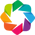

In [26]:
import pandas as pd
import numpy as np
import holoviews as hv
from collections import defaultdict
import math

from progressbar import ProgressBar

import rnaseq_lib as r

hv.extension('bokeh')

## Input

In [36]:
def load_data():
    # Expression dataframe
    df_path = '/mnt/gene-expression-processing/TCGA-GTEx-RSEM-counts-protein-coding.deseq2-normalized.tsv'
    df = pd.read_csv(df_path, index_col=0, sep='\t')

    # Sample Metadata
    met_path = '/mnt/rna-seq-analysis/metadata/tcga_gtex_metadata_intersect.tsv'
    met = pd.read_csv(met_path, index_col=0, sep='\t')

    # ~500 gene subset
    ucsf_df = r.tissues.get_ucsf_subset(df)
    
    return ucsf_df, met

ucsf_df, met = None, None

In [35]:
# Sample Metadata
met_path = '/mnt/rna-seq-analysis/metadata/tcga_gtex_metadata_intersect.tsv'
met = pd.read_csv(met_path, index_col=0, sep='\t')

## Collect plot information

In [4]:
# Check for dataframe of t-ETE values, if not present, run
r.utils.mkdir_p('pandas')
name = 'pandas/dataset-ucsf500.pandas'
try:
    info = pd.read_pickle(name)
except IOError:
    # Loading Data
    ucsf_df, met = load_data()
    
    # Collect samples and run t-ete
    samples = list(set([x for x in met.id if x in ucsf_df.columns]))
    z = r.dim_red.run_tete(ucsf_df[samples].T)
    
    # Create dataframe by merging metadata and t-ETE values
    info = pd.concat([met[~met.id.duplicated()].loc[samples],  # Metadata table, dropping duplicate IDs 
                      pd.DataFrame(z, columns=['x', 'y'], index=samples)], axis=1)  # t-ETE values
    
    # Serialize
    info.to_pickle(name)

In [5]:
info.head(2)

id      reads      size_MB  \
GTEX-S4Q7-0003-SM-3NM8M  GTEX-S4Q7-0003-SM-3NM8M   76809703  6024.000000   
TCGA-S9-A7J2-01                  TCGA-S9-A7J2-01  140863304  6289.175857   

                               platform   sex tissue seq_site  weight  height  \
GTEX-S4Q7-0003-SM-3NM8M  Illumina HiSeq  male  Cells       BI   176.0    66.0   
TCGA-S9-A7J2-01          Illumina HiSeq  male  Brain      UNC     NaN     NaN   

                         mapped_reads   race   age    qc dataset tumor  \
GTEX-S4Q7-0003-SM-3NM8M   117798545.0  white  22.0  10.0    gtex    no   
TCGA-S9-A7J2-01           138482222.0  white  22.0   9.6    tcga   yes   

                                                     type          x  \
GTEX-S4Q7-0003-SM-3NM8M  Cells_EBVtransformed_lymphocytes  24.029710   
TCGA-S9-A7J2-01                  Brain_Lower_Grade_Glioma  27.543218   

                                 y  
GTEX-S4Q7-0003-SM-3NM8M -26.701579  
TCGA-S9-A7J2-01           3.775551

# Entire Dataset

In [8]:
# Create list of visual dimensions (y first so its default)
vdims = ['y'] + [x for x in info.columns if x not in ['x', 'y', 'reads', 'size_MB', 'mapped_reads']]

plot = hv.Scatter(data=info, kdims=['x'], vdims=vdims, group='TCGA and GTEx Dataset')

In [120]:
%opts Overlay [tabs=True]
%opts Scatter [width=1000 height=700 tools=['hover'] color_index='tissue' legend_position='left']
%opts Scatter (cmap='tab20')
plot

:Scatter   [x]   (y,id,platform,sex,tissue,seq_site,weight,height,race,age,qc,dataset,tumor,type)

# Iteratively Remove Furthest Tissue

Remove samples in a tissue whose centroid is furthest away from other samples every iteration then plot

In [119]:
# rplots will store our "recursive" plots
rplots = {}

# Copy dataframe information as a template, dropping the t-ete info
temp_info = info.copy()

# For storing table information
cols = []  # Column ordering based on which tissue is dropped first
vals = []  # list(list(str)) of distanc values

# Iterate through all tissues
bar = ProgressBar()
for i in bar(xrange(len(info.tissue.unique()) - 1)):

    # Calculate centroid distances
    dists = {}
    for t in temp_info.tissue.unique():
        
        # Calculate centroid
        x = temp_info[temp_info.tissue == t].x.mean()
        y = temp_info[temp_info.tissue == t].y.mean()
        
        # Calculate centroid of all other samples
        x_o = temp_info[temp_info.tissue != t].x.mean()
        y_o = temp_info[temp_info.tissue != t].y.mean()
        
        # Calculate distance
        dists[t] = math.hypot(x_o - x, y_o - y)
    
    # Find tissue that is furthest away
    furthest_tissue = max(dists.iterkeys(), key=lambda x: dists[x])
    
    # Add ordering information for columns
    cols.insert(0, furthest_tissue)
    
    # Remove tissue from table
    temp_info = temp_info[info.tissue != furthest_tissue]
    
    # Run tsne and merge to dataframe
    name = '{}-{}'.format(i, furthest_tissue)
    output = 'pandas/{}.panda'.format(name)
    try:
        rplots[name] = pd.read_pickle(output)
    except IOError:
        if ucsf_df is not None:
            # Load data if it hasn't been
            ucsf_df, met = load_data()
            
        # Get samples for new run
        samples = list(set([x for x in temp_info.id.unique() if x in ucsf_df]))

        # Run t-SNE
        z = r.dim_red.run_tete(df=ucsf_df[samples].T, num_neighbors=10)

        # Create dataframe
        rplots[name] = pd.concat([temp_info[~temp_info.id.duplicated()].loc[samples],
                                  pd.DataFrame(z, columns=['x', 'y'], index=samples)], axis=1)
        
        # Save
        rplots[name].to_pickle(output)

        # Create list of visual dimensions (y first so its default)
        vdims = ['y'] + [x for x in info.columns if x not in 
                         ['x', 'y', 'reads', 'size_MB', 'mapped_reads']]
    
    # Set temp_info to rplots[name] which includes updated t-ETE x,y information
    temp_info = rplots[name]
    
    # Create plot object
    rplots[name] = hv.Scatter(data=rplots[name], kdims=['x'], vdims=vdims, 
                              group='TCGA and GTEx: Iter {}, Tissue-removed: {}'.format(i + 1, furthest_tissue))

AttributeError: 'DataFrame' object has no attribute 'x'

Save distance information dataframe

In [117]:
dists = pd.DataFrame.from_records(vals, columns=sorted(info.tissue.unique()))

# Order columns by order tissue was removed
dists = dists[cols]
r.utils.mkdir_p('output')
dists.to_csv('output/dists.tsv', sep='\t')
dists.head(20)

Thymus       Eye    Uterus     Ovary  Small_intestine     Lymph  \
0   2.685014  2.742288  3.940326  4.791089         5.644394  7.060336   
1   2.685014  2.742288  3.940326  4.791089         5.644394  7.060336   
2   2.685014  2.742288  3.940326  4.791089         5.644394  7.060336   
3   2.685014  2.742288  3.940326  4.791089         5.644394  7.060336   
4   2.685014  2.742288  3.940326  4.791089         5.644394  7.060336   
5   2.685014  2.742288  3.940326  4.791089         5.644394  7.060336   
6   2.685014  2.742288  3.940326  4.791089         5.644394  7.060336   
7   2.685014  2.742288  3.940326  4.791089         5.644394  7.060336   
8   2.685014  2.742288  3.940326  4.791089         5.644394  7.060336   
9   2.685014  2.742288  3.940326  4.791089         5.644394  7.060336   
10  2.685014  2.742288  3.940326  4.791089         5.644394  7.060336   
11  2.685014  2.742288  3.940326  4.791089         5.644394  7.060336   
12  2.685014  2.742288  3.940326  4.791089         5.644394  7.060336   
13  2.685014  2.742288  3.940326  4.791089         5.644394  7.060336   
14  2.685014  2.742288  3.940326  4.791089         5.644394  7.060336   
15  2.685014  2.742288  3.940326  4.791089         5.644394  7.060336   
16  2.685014  2.742288  3.940326  4.791089         5.644394  7.060336   
17  2.685014  2.742288  3.940326  4.791089         5.644394  7.060336   
18  2.685014  2.742288  3.940326  4.791089         5.644394  7.060336   
19  2.685014  2.742288  3.940326  4.791089         5.644394  7.060336   

      Pleura    Cervix      Lung    Breast    ...     Fallopian    Adipose  \
0   7.326834  7.453586  7.684436  9.661561    ...     22.174602  23.553027   
1   7.326834  7.453586  7.684436  9.661561    ...     22.174602  23.553027   
2   7.326834  7.453586  7.684436  9.661561    ...     22.174602  23.553027   
3   7.326834  7.453586  7.684436  9.661561    ...     22.174602  23.553027   
4   7.326834  7.453586  7.684436  9.661561    ...     22.174602  23.553027   
5   7.326834  7.453586  7.684436  9.661561    ...     22.174602  23.553027   
6   7.326834  7.453586  7.684436  9.661561    ...     22.174602  23.553027   
7   7.326834  7.453586  7.684436  9.661561    ...     22.174602  23.553027   
8   7.326834  7.453586  7.684436  9.661561    ...     22.174602  23.553027   
9   7.326834  7.453586  7.684436  9.661561    ...     22.174602        NaN   
10  7.326834  7.453586  7.684436  9.661561    ...           NaN        NaN   
11  7.326834  7.453586  7.684436  9.661561    ...           NaN        NaN   
12  7.326834  7.453586  7.684436  9.661561    ...           NaN        NaN   
13  7.326834  7.453586  7.684436  9.661561    ...           NaN        NaN   
14  7.326834  7.453586  7.684436  9.661561    ...           NaN        NaN   
15  7.326834  7.453586  7.684436  9.661561    ...           NaN        NaN   
16  7.326834  7.453586  7.684436  9.661561    ...           NaN        NaN   
17  7.326834  7.453586  7.684436  9.661561    ...           NaN        NaN   
18  7.326834  7.453586  7.684436  9.661561    ...           NaN        NaN   
19  7.326834  7.453586  7.684436  9.661561    ...           NaN        NaN   

       Spleen      Nerve  Pituitary     Artery      Brain     Testis  \
0   27.418886  30.342977  32.275704  37.287769  37.765393  38.556835   
1   27.418886  30.342977  32.275704  37.287769  37.765393  38.556835   
2   27.418886  30.342977  32.275704  37.287769  37.765393  38.556835   
3   27.418886  30.342977  32.275704  37.287769  37.765393        NaN   
4   27.418886  30.342977  32.275704  37.287769        NaN        NaN   
5   27.418886  30.342977  32.275704        NaN        NaN        NaN   
6   27.418886  30.342977        NaN        NaN        NaN        NaN   
7   27.418886        NaN        NaN        NaN        NaN        NaN   
8         NaN        NaN        NaN        NaN        NaN        NaN   
9         NaN        NaN        NaN        NaN        NaN        NaN   
10        NaN        NaN        NaN      

# Iterative Plots

## Vdim of tissue:type / non-tissue

In [5]:
met.tissue.unique()

array(['Stomach', 'Skin', 'Cervix', 'Uterus', 'Thyroid', 'Testis',
       'Prostate', 'Breast', 'Ovary', 'Pleura', 'Esophagus', 'Bone_marrow',
       'Kidney', 'Colon', 'Adrenal', 'Lung', 'Liver', 'Head', 'Brain',
       'Soft_tissue', 'Eye', 'Bladder', 'Lymph', 'Pancreas', 'Thymus',
       'Bile', 'Heart', 'Adipose', 'Nerve', 'Muscle', 'Whole', 'Artery',
       'Cells', 'Small_intestine', 'Pituitary', 'Vagina', 'Spleen',
       'Minor', 'Fallopian'], dtype=object)

In [ ]:
%%time
# Create dictionary to store results
info = r.utils.Expando.MagicExpando()

# Create a "template" dataframe to build off of
temp = met[['id', 'sex', 'tissue', 'dataset', 'tumor', 'type']].drop_duplicates()

# Create output directory for pandas dataframes if it doesn't exist
r.utils.mkdir_p('pandas')

# Iterate and run t-ETE
bar = ProgressBar()
for tissue in bar(sorted(tissues)):
    samples = [x for x in met[met.tissue == tissue].id.unique() if x in df.columns]
    
    # Run t-ETE for protein-coding genes
    name = 'pandas/{}-pc.pandas'.format(tissue)
    try:
        info[tissue]['pc'] = pd.read_pickle(name)
    except IOError:
        pc = r.dim_red.run_tete(df[samples].T)
        info[tissue]['pc'] = pd.concat([temp.loc[samples], pd.DataFrame(pc, columns=['x', 'y'], index=samples)], axis=1)
        info[tissue]['pc'].to_pickle(name)
    
    # Run t-ETE for UCSF500 genes
    name = 'pandas/{}-ucsf.pandas'.format(tissue)
    try:
        info[tissue]['ucsf'] = pd.read_pickle(name)
    except IOError:        
        ucsf = r.dim_red.run_tete(ucsf_df[samples].T)
        info[tissue]['ucsf'] = pd.concat([temp.loc[samples], pd.DataFrame(ucsf, columns=['x', 'y'], index=samples)], axis=1)
        info[tissue]['ucsf'].to_pickle(name)